In [1]:
import hydra
from glob import  glob
from rosa.data import  RosaDataModule, create_io_paths
from rosa.modeling import  RosaLightningModule


BASE_DIR = "/home/ec2-user/rosa/conf/" # /Users/nsofroniew/Documents/GitHub/ or /home/ec2-user/

with hydra.initialize_config_dir(config_dir=BASE_DIR):
    config = hydra.compose(config_name="config")
    config.paths.base = '/home/ec2-user/cell_census' # '/Users/nsofroniew/Documents/data/multiomics/cell_census'

    _, output_path = create_io_paths(config.paths)

    # config.data_module.data.mask = 0.01
    # config.data_module.data.n_var_sample = 1000
    # Create Data Module
    rdm = RosaDataModule(
        output_path,
        config=config.data_module,
    )
    rdm.setup()
    print(output_path)

/tmp/ipykernel_29913/3063327940.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=BASE_DIR):
/opt/conda/envs/pytorch/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


/home/ec2-user/cell_census/tabula_sapiens__trio_top5_pc__sample_donor_id__label_cell_type.h5ad


In [2]:
from tqdm import tqdm
import torch


expression = []
for item in tqdm(rdm.predict_dataset):
    expression.append(item['expression_target'])
expression = torch.stack(expression, dim=0)

100%|██████████| 369/369 [00:00<00:00, 1772.35it/s]


In [3]:
expression = expression.detach().numpy()

In [ ]:
from pyensembl import EnsemblRelease

genome = EnsemblRelease(77)

def get_num_tss(gene_id):
    gene = genome.gene_by_id(gene_id)
    transcripts = [ts for ts in gene.transcripts if ts.biotype == 'protein_coding']
    return len(transcripts)


In [ ]:
num_tss = [get_num_tss(gene_id) for gene_id in list(rdm.train_dataset.adata.var.index)]

In [ ]:
import numpy as np
num_tss = np.array(num_tss)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(num_tss, bins=np.linspace(0, 20, 20));

In [ ]:
gene_id = rdm.train_dataset.adata.var.index[13695]
gene = genome.gene_by_id(gene_id)

In [ ]:
gene.transcripts

In [ ]:
[ts for ts in gene.transcripts if ts.biotype == 'protein_coding']

In [ ]:
list(rdm.train_dataset.adata.varm.keys())

In [ ]:
# var_input = rdm.train_dataset.var_input[3]

In [ ]:
# var_input = var_input / num_tss[:, None]

In [ ]:
# var_input = rdm.train_dataset.var_input[[0, 3, 5, 8, 4, 6, 7, 1, 13, 12, 10]].swapaxes(0, 1).reshape(19431, -1)
# var_input = var_input.detach().numpy()

In [ ]:
# from sklearn.decomposition import PCA


# # fit pca on training data
# pca = PCA()
# pca.fit(var_input)
# pca_embedding = pca.transform(var_input)

In [ ]:
# np.cumsum(pca.explained_variance_ratio_)

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlim([0, 512])

In [ ]:
# np.cumsum(pca.explained_variance_ratio_)[320]

In [ ]:
# var_input_pca = pca_embedding #[:, :10_000]

In [ ]:
# var_input_pca.shape

In [157]:
# var_input = rdm.train_dataset.var_input[12]
# var_input = torch.rand(var_input.shape)
# var_input = rdm.train_dataset.var_input[[0, 1, 5]].sum(axis=0)
# var_input = rdm.train_dataset.var_input[[2, 3, 4]].sum(axis=0)

# var_input = rdm.train_dataset.var_input[[0, 3, 6, 9, 12]].swapaxes(0, 1).reshape(19431, -1)
# var_input = rdm.train_dataset.var_input[[2, 3, 4]].swapaxes(0, 1).reshape(19431, -1)
var_input = rdm.train_dataset.var_input[:].swapaxes(0, 1).reshape(19431, -1)


In [158]:
X_predict = var_input
X_train = var_input[rdm.train_dataset.var_indices]
y_train = expression[:, rdm.train_dataset.var_indices].T

In [159]:
from sklearn import linear_model
from sklearn.multioutput import MultiOutputClassifier


ALPHA = 100

model = linear_model.Ridge(alpha=ALPHA).fit(X_train, y_train)
# model = MultiOutputClassifier(linear_model.RidgeClassifier(alpha=ALPHA)).fit(X_train, y_train)

In [ ]:
n_bins = 8

In [ ]:
import numpy as np


y_predict = model.predict(X_predict)
y_predict = np.round(np.clip(y_predict, 0, n_bins-1))

In [ ]:
y_predict.max()

7.0

In [ ]:
y_predict.min()

0.0

In [ ]:
adata = rdm.predict_dataset.adata
adata.layers['predicted'] = y_predict.T
adata.layers['target'] = expression

obs_indices = rdm.val_dataset.obs_indices.detach().numpy()
var_bool = rdm.val_dataset.mask_bool.detach().numpy()
adata_predict = adata[obs_indices, var_bool]
adata_predict.uns['nbins'] = n_bins

/opt/conda/envs/pytorch/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [ ]:
from rosa.utils import score_predictions

In [ ]:
target = torch.from_numpy(expression)
predicted = torch.from_numpy(y_predict.T)

scores = score_predictions(predicted, target, nbins=n_bins)


In [ ]:
print(
    f"""
    mean spearman across genes {scores['spearman_obs_mean']:.3f}
    mean spearman across cells {scores['spearman_var_mean']:.3f}
    """
)  


    mean spearman across genes 0.811
    mean spearman across cells 0.595
    


In [ ]:
# tabula_sapiens__trio_top5_pc__sample_donor_id__label_cell_type.h5ad

# embedding_amax_0 cat [0, 3]
    # mean spearman across genes 0.770
    # mean spearman across cells 0.497

# embedding_amax_0 cat [0, 3, 6]
    # mean spearman across genes 0.782
    # mean spearman across cells 0.527

# embedding_amax_0 cat [0, 3, 6, 9]
    # mean spearman across genes 0.793
    # mean spearman across cells 0.553

# embedding_amax_0 cat [0, 3, 6, 9, 12]
    # mean spearman across genes 0.801
    # mean spearman across cells 0.574


# embedding_amax_0 cat all
    # mean spearman across genes 0.850 XXXX
    # mean spearman across cells 0.709 XXXX

# embedding_amax_0 cat :12
    # mean spearman across genes 0.844
    # mean spearman across cells 0.689

# embedding_amax_0 cat :6
    # mean spearman across genes 0.811
    # mean spearman across cells 0.595


# embedding_amax_0 0
    # mean spearman across genes 0.753
    # mean spearman across cells 0.460

# embedding_amax_1 3
    # mean spearman across genes 0.739
    # mean spearman across cells 0.452

# embedding_amax_2 6
    # mean spearman across genes 0.732
    # mean spearman across cells 0.448

# embedding_amax_3 9
    # mean spearman across genes 0.726
    # mean spearman across cells 0.446

# embedding_amax_4 12
    # mean spearman across genes 0.719
    # mean spearman across cells 0.443


# random
    # mean spearman across genes 0.264
    # mean spearman across cells 0.320

In [ ]:
list(rdm.train_dataset.adata.varm.keys())

['embedding_amax_0',
 'embedding_amax_0_1',
 'embedding_amax_0_m1',
 'embedding_amax_1',
 'embedding_amax_1_1',
 'embedding_amax_1_m1',
 'embedding_amax_2',
 'embedding_amax_2_1',
 'embedding_amax_2_m1',
 'embedding_amax_3',
 'embedding_amax_3_1',
 'embedding_amax_3_m1',
 'embedding_amax_4',
 'embedding_amax_4_1',
 'embedding_amax_4_m1']

In [ ]:
# tabula_sapiens__trio_pc__sample_donor_id__label_cell_type.h5ad
# embedding 0
    # mean spearman across genes 0.702
    # mean spearman across cells 0.435

# embedding_1 1
    # mean spearman across genes 0.704
    # mean spearman across cells 0.434

# embedding_amax 2
    # mean spearman across genes 0.753
    # mean spearman across cells 0.460

# embedding_amax_1 3
    # mean spearman across genes 0.746
    # mean spearman across cells 0.454

# embedding_amax_m1 4
    # mean spearman across genes 0.733
    # mean spearman across cells 0.447

# embedding_m1 5
    # mean spearman across genes 0.688
    # mean spearman across cells 0.426

# sum embedding 0,-1,1 [0, 1, 5]
    # mean spearman across genes 0.688?
    # mean spearman across cells 0.426?

# sum embedding_amax 0,-1,1 [2, 3, 4]
    # mean spearman across genes 0.751
    # mean spearman across cells 0.465

# cat embedding 0,-1,1 [0, 1, 5]
    # mean spearman across genes 0.739
    # mean spearman across cells 0.497

# cat embedding_amax 0,-1,1 [2, 3, 4]
    # mean spearman across genes 0.779
    # mean spearman across cells 0.518

# cat embedding 0 amax 0 [0, 2]
    # mean spearman across genes 0.770
    # mean spearman across cells 0.492

# cat embedding 0 amax 0 all
    # mean spearman across genes 0.811
    # mean spearman across cells 0.589

In [ ]:
# tabula_sapiens__all_pc__sample_donor_id__label_cell_type.h5ad
# All concat
    # mean spearman across genes 0.716
    # mean spearman across cells 0.477

# Concat [0, 3, 4, 5, 6, 7, 8]
    # mean spearman across genes 0.814
    # mean spearman across cells 0.609

# Concat [3, 4, 5, 6, 7, 8]
    # mean spearman across genes 0.801
    # mean spearman across cells 0.581

# Concat [0, 3]
    # mean spearman across genes 0.770
    # mean spearman across cells 0.492

# Concat [0, 3, 5]
    # mean spearman across genes 0.782
    # mean spearman across cells 0.521

# Concat [0, 3, 5, 8]
    # mean spearman across genes 0.791
    # mean spearman across cells 0.543

# Concat [0, 3, 5, 8, 4]
    # mean spearman across genes 0.799
    # mean spearman across cells 0.564

# Concat [0, 3, 5, 8, 4, 6]
    # mean spearman across genes 0.807
    # mean spearman across cells 0.586

# Concat [0, 3, 5, 8, 4, 7, 1]
    # mean spearman across genes 0.823
    # mean spearman across cells 0.638

# Concat [0, 3, 5, 4, 7]
    # mean spearman across genes 0.803
    # mean spearman across cells 0.577

# Concat [0, 3, 5, 8, 4, 6, 7, 1, 2]
    # mean spearman across genes 0.675
    # mean spearman across cells 0.440

# Concat [0, 3, 5, 8, 4, 6, 7, 1, 13]
    # mean spearman across genes 0.831
    # mean spearman across cells 0.673

# Concat [0, 3, 5, 8, 4, 6, 7, 1, 13, 12]
    # mean spearman across genes 0.832
    # mean spearman across cells 0.690

# Concat [0, 3, 5, 8, 4, 6, 7, 13, 12]
    # mean spearman across genes 0.824
    # mean spearman across cells 0.663

# All but 2 concat
    # mean spearman across genes 0.680
    # mean spearman across cells 0.416

# Concat [0, 3, 5, 8, 4, 6, 7, 1, 13, 12, 10]
    # mean spearman across genes 0.831 XXXXX
    # mean spearman across cells 0.701 XXXXX

# Concat [0, 3, 5, 8, 4, 6, 7, 1, 13, 12, 10, 9]
    # mean spearman across genes 0.685
    # mean spearman across cells 0.419

# Concat [0, 3, 13]
    # mean spearman across genes 0.781
    # mean spearman across cells 0.534

In [ ]:
# tabula_sapiens__all_pc__sample_donor_id__label_cell_type.h5ad
# embedding 0
    # mean spearman across genes 0.702
    # mean spearman across cells 0.435

# embedding_sum 1
    # mean spearman across genes 0.540
    # mean spearman across cells 0.377

# embedding_amax 2
    # mean spearman across genes 0.592
    # mean spearman across cells 0.416

# embedding_tss_amax 3
    # mean spearman across genes 0.753
    # mean spearman across cells 0.460

# embedding_tss_amax_16 4
    # mean spearman across genes 0.724
    # mean spearman across cells 0.448

# embedding_tss_amax_3 5
    # mean spearman across genes 0.741
    # mean spearman across cells 0.454

# embedding_tss_amax_32 6
    # mean spearman across genes 0.708
    # mean spearman across cells 0.442

# embedding_tss_amax_64 7
    # mean spearman across genes 0.675
    # mean spearman across cells 0.431

# embedding_tss_amax_8 8
    # mean spearman across genes 0.734
    # mean spearman across cells 0.451

# embedding_tss_sum 9
    # mean spearman across genes 0.556
    # mean spearman across cells 0.318

# embedding_tss_sum_16
    # mean spearman across genes 0.595
    # mean spearman across cells 0.342

# embedding_tss_sum_3
    # mean spearman across genes 0.577
    # mean spearman across cells 0.332

# embedding_tss_sum_32
    # mean spearman across genes 0.597
    # mean spearman across cells 0.342

# embedding_tss_sum_64
    # mean spearman across genes 0.592
    # mean spearman across cells 0.338

# embedding_tss_sum_8
    # mean spearman across genes 0.590
    # mean spearman across cells 0.339


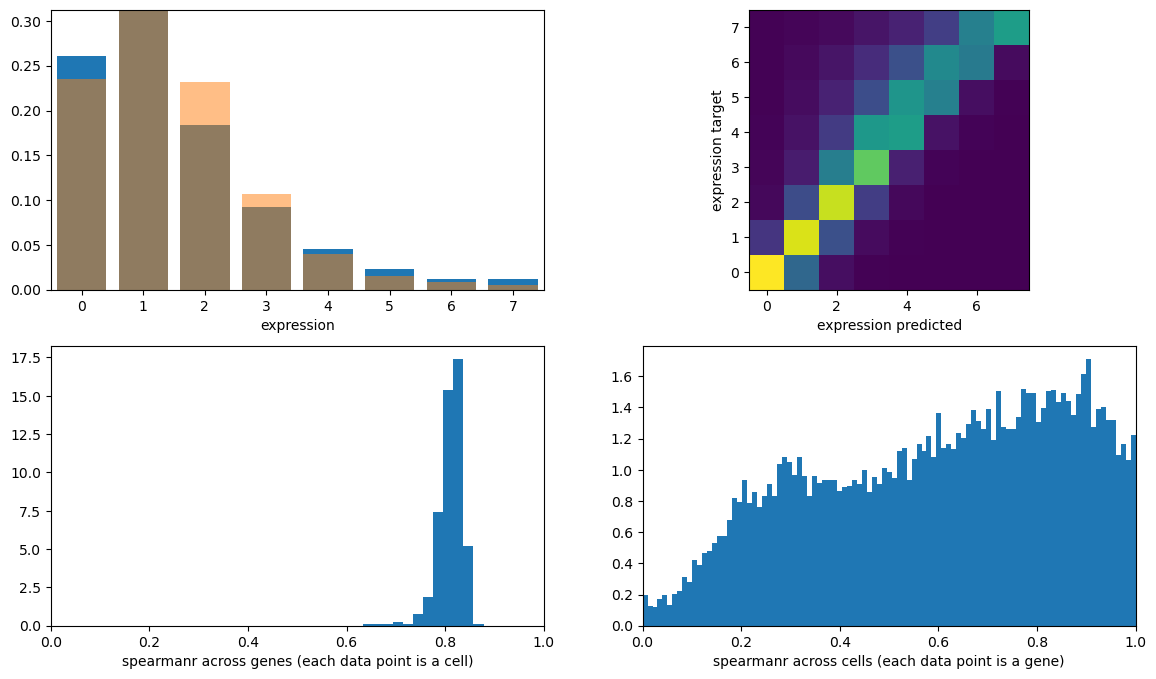

In [ ]:
from rosa.utils import plot_expression_and_correlation, plot_marker_gene_heatmap
  
plot_expression_and_correlation(scores)

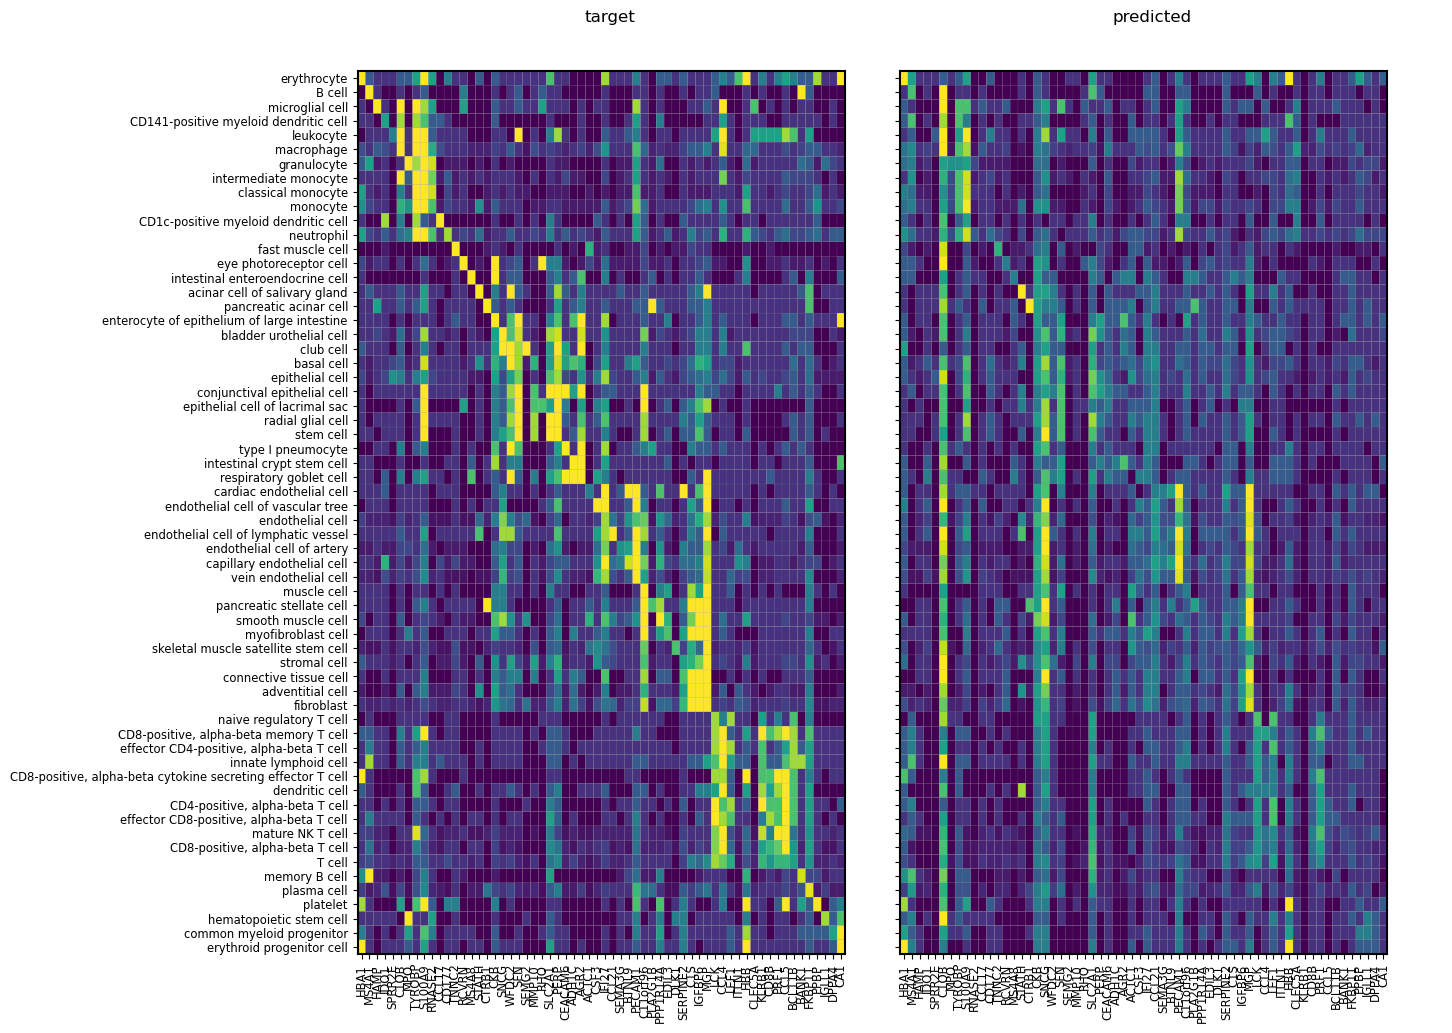

In [ ]:
import scanpy as sc

marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']
sc.tl.dendrogram(adata_predict, groupby="label", use_rep="X")
plot_marker_gene_heatmap(adata_predict, marker_genes_dict)

In [ ]:
111

In [ ]:
a = sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=8,
    show=False,
    dendrogram=True,
)

In [ ]:
adata_predict.layers['predicted'].max()

In [ ]:
sc.pl._matrixplot.MatrixPlot

In [ ]:
from scanpy.plotting._matrixplot import MatrixPlot

In [ ]:
mp_c = MatrixPlot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="confidence",
    vmin=0,
    vmax=6,
    show=False,
    dendrogram=False,
)

In [ ]:
mp_p = MatrixPlot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="target",
    vmin=0,
    vmax=7,
    show=False,
    dendrogram=True,
)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mp_p.values_df.values)

In [ ]:
mp_p.add_dendrogram(dendrogram_key=True)

_color_df = mp_p.values_df.copy()
if mp_p.var_names_idx_order is not None:
    _color_df = _color_df.iloc[:, mp_p.var_names_idx_order]

if mp_p.categories_order is not None:
    _color_df = _color_df.loc[mp_p.categories_order, :]

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(_color_df)

In [ ]:
mp_p.categories_order

In [ ]:
mp_p.var_names_idx_order

In [ ]:
adata_predict.obs['label']

In [ ]:
import torch

target = torch.from_numpy(adata_predict.layers['target'])
preds = torch.from_numpy(adata_predict.layers['predicted'])
conf = torch.from_numpy(adata_predict.layers['confidence'])
num_classes = adata_predict.uns['nbins']

In [ ]:
unique_mapping = target.to(torch.long) * num_classes + preds.to(torch.long)
cm = torch.bincount(unique_mapping.ravel(), minlength=num_classes**2).reshape(num_classes, num_classes).numpy()

In [ ]:
cm_conf = torch.bincount(unique_mapping.ravel(), weights=conf.ravel(), minlength=num_classes**2).reshape(num_classes, num_classes).numpy()
cm_conf = cm_conf / cm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


bins = np.arange(nbins)
xlim = [-0.5, num_classes - 0.5]

_, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={"wspace": 0.2})

# Subplot with confusion matrix
axs[0].imshow(cm / cm.sum(axis=1)[:, np.newaxis], cmap='Blues')
axs[0].set_xlim(xlim)
axs[0].set_ylim(xlim)
axs[0].set_aspect("equal", adjustable="box")
axs[0].set_xlabel("expression predicted")
axs[0].set_ylabel("expression target")
axs[0].set_title("confusion matrix")

axs[1].imshow(cm_conf, cmap='Blues')
axs[1].set_xlim(xlim)
axs[1].set_ylim(xlim)
axs[1].set_aspect("equal", adjustable="box")
axs[1].set_xlabel("expression predicted")
axs[1].set_ylabel("expression target")
axs[1].set_title("confidence")

axs[2].imshow(cm / cm.sum(axis=1)[:, np.newaxis], alpha=cm_conf, cmap='Blues')
axs[2].set_xlim(xlim)
axs[2].set_ylim(xlim)
axs[2].set_aspect("equal", adjustable="box")
axs[2].set_xlabel("expression predicted")
axs[2].set_ylabel("expression target")
axs[2].set_title("confusion matrix with confidence transparency")

In [ ]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

In [ ]:
marker_genes_dict

In [ ]:
adata_predict.obs['cell_type']

## Extras

In [ ]:
# import seaborn as sns
# from scipy.cluster.hierarchy import linkage
# import sys


# sys.setrecursionlimit(100000)

In [ ]:
# row_linkage = linkage(adata_predict.layers['measured']) # D being the measurement
# col_linkage = linkage(adata_predict.layers['measured'].T) # D being the measurement
# sns.clustermap(adata_predict.layers['measured'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['predicted'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['confidence'], row_linkage=row_linkage, col_linkage=col_linkage)

## Value histograms

In [ ]:
import numpy as np

In [ ]:
values, counts = np.unique(adata_predict.layers['target'], return_counts=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(values, counts)

In [ ]:
values

In [ ]:
counts

In [ ]:
import torch

In [ ]:
from tqdm import tqdm

In [ ]:
adata_predict.layers['counts'][:5, :5]

In [ ]:
adata_predict.X[:5, :5]

In [ ]:
full_binned = []
full_boundaries = []

n_bins = 8
for i, row in tqdm(enumerate(adata_predict.X)):
    tensor = torch.Tensor(row)

    boundaries = [torch.tensor(0.0)]
    for q in range(n_bins - 2):
        data_remaining = tensor[tensor>boundaries[-1]]
        n_data_remaining = len(data_remaining)
        if n_data_remaining == 0:
            next_val = boundaries[-1]
        else:
            n_bins_remaining = n_bins - q - 1
            factor = np.exp(np.log(n_data_remaining) / n_bins_remaining)
            next_quantile = 1 / 2
            next_val = max(boundaries[-1]+1e-5, torch.quantile(data_remaining, next_quantile))
            next_val = torch.quantile(data_remaining, next_quantile)
        boundaries.append(next_val)
    boundaries = torch.stack(boundaries, dim=0)

    full_binned.append(torch.bucketize(tensor, boundaries))
    full_boundaries.append(boundaries)
full_binned = torch.cat(full_binned, dim=0)
full_boundaries = torch.stack(full_boundaries)

In [ ]:
full_boundaries[2]

In [ ]:
full_boundaries[2]

In [ ]:
full_boundaries[12]

In [ ]:
full_boundaries[:, -1]

In [ ]:
values, counts = torch.unique(full_binned, return_counts=True)

In [ ]:
print(values)
print(counts)

In [ ]:
plt.plot(counts)

In [ ]:
len(row)

In [ ]:
x = np.exp(np.log(5792) / 16)

In [ ]:
5792 / x**15

In [ ]:
import numpy as np
from scipy.optimize import minimize_scalar

def geometric_series_r(n, Q):
    def series_sum(r):
        return (1 - r**n) / (1 - r) - Q

    res = minimize_scalar(series_sum, bounds=(0, 1), method='bounded')
    return res.x

n = 5  # Number of steps
Q = 12005  # Sum of the geometric series

r = geometric_series_r(n, Q)
print(f"Approximate value of r: {r:.5f}")


In [ ]:
geometric_series_r(16, 5792)

In [ ]:
4.439545990918005e-06 + 4.439545990918005e-06^2

In [ ]:
plt.plot(values, counts)

In [ ]:
values, counts = torch.unique(expression, return_counts=True)
nbins = self.transform[-1].n_bins
bin_counts = torch.zeros(nbins, dtype=torch.long)
bin_counts[values] = counts
mask_indices = torch.multinomial(1 / bin_counts[expression], int(self.mask * len(expression)))
mask = torch.zeros(expression.shape, dtype=torch.bool)
mask[mask_indices] = True

mask_type = torch.rand(1)
if mask_type < self.pass_through:
    pass
elif mask_type < self.corrupt:
    count_inds = torch.multinomial(counts, len(mask_indices))
    expression[mask] = values[count_inds]

In [ ]:
if torch.rand(1) < 0.3:
    print('a')

## Scanpy plots

In [ ]:
import scanpy as sc

In [ ]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer=None,
    vmin=0,
    vmax=1e2,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='confidence',
    vmin=0,
    vmax=1,
    show=False,
    title='confidence',
    dendrogram=True,
)

In [ ]:
sc.pl.dotplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
marker_genes_dict_2 = {}

for key, value in list(marker_genes_dict.items())[:20]:
    marker_genes_dict_2[key] = value

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="measured",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes['heatmap_ax'].clear()

In [ ]:
for a in axes['heatmap_ax'].lines:
    print(a)

In [ ]:
axes

In [ ]:
del axes['gene_groups_ax']

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)